In [1]:
import imports
import importlib
importlib.reload(imports)
from imports import *

# torch.cuda.is_available(), torch.rand(1).to('cuda:0')

ModuleNotFoundError: No module named 'nerus'

In [ ]:
from async_dataset_reader2 import AsyncDatasetReader, AsyncDatasetLoaderToGPU
dataset_mem_reader = AsyncDatasetReader(path="cache2/storage", max_kept_in_memory=2, writer=None)
dataset_to_gpu_loader = AsyncDatasetLoaderToGPU(dataset_mem_reader, max_kept_in_memory=2, test_samples_count=20000, writer=None)

dataset_to_gpu_loader.first_loaded_event.wait()
params = dataset_mem_reader.params

In [3]:
i, x, y = dataset_mem_reader.get_chunk_on_gpu([])

iter 0


removed  0
reading 3 (last_read=0)
read 3


In [3]:
from storage import Storage
storage = Storage("cache2/storage")
storage.get("x", 0).shape

torch.Size([15897, 16, 489])

In [12]:
torch.isnan(storage.get("x", 0)).any()

tensor(False)

In [2]:
class LSTM(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.lstm = nn.LSTM(INTERNAL_EMBEDDING_SIZE2, INTERNAL_EMBEDDING_SIZE2 // 2, 
                            num_layers=1, batch_first=True, bidirectional=True)
    def forward(self, x):
        return self.lstm(x)[0]

In [ ]:
import torch
import pytorch_warmup as warmup



In [7]:
prefix = "results writers big"
print("ADD RESULTS ")
with open(f"{prefix}/some_model_CLASS.dill", "rb") as file:
    Model = dill.load(file)
model = torch.load(f"{prefix}/some_model.pt", map_location=torch.device('cpu')) #).v1", map_location=torch.device('cuda:0'))

with open(f"{prefix}/storage_path.dill", "rb") as file:
    storage_path = dill.load(file)
with open(f"{prefix}/is_infected_test.dill", "rb") as file:
    is_infected = dill.load(file)

storage = Storage(str(storage_path))
params = storage.get_meta("params")

x_test = storage.get_meta("x_test").float()
y_test = storage.get_meta("y_test").float()
text_res = storage.get_meta("text_res_test")
is_infected = storage.get_meta("is_infected_test")

# test_indices = ~is_infected
# x_test = storage.get("x", 0)[:len(is_infected)].float()
# y_test = storage.get("y", 0)[:len(is_infected)].float()
# text_res = np.array(storage.get("text_res", 0), dtype='object')[:len(is_infected)]

#[i] for i in range(len(test_indices)) if test_indices[i]]

ADD RESULTS 


In [96]:
from dataset_lib import get_lenta_records
import stream
importlib.reload(stream)
from stream import Stream
for i in Stream(get_lenta_records()).skip(5003).limit(10000):#.map(lambda record: record.text):
    print(i)
    break

LentaRecord(url='https://lenta.ru/news/2000/03/07/fifa/', title='ФИФА разберется со\xa0стероидами', text='На ближайшем заседании, намеченном на 23-24 марта, исполком ФИФА будет разбираться с "делом нандролона", о чем было объявлено в понедельник. В специальном заявлении ФИФА говорится, что ассоциация не станет вычеркивать этот анаболический стероид из списка запрещенных к употреблению препаратов. Между тем последние исследования подтвердили, что нандролон может вырабатываться человеческим организмом естественным путем в результате физических нагрузок. По словам пресс-секретаря ФИФА Андреаса Херрона, вопрос не в том,  нужно ли считать нандролон допингом (таковым его считают и будут считать впредь ), а в том, как научиться  точно определять, что тот или иной футболист его применяет. Напомним, что жертвами стероида стали уже несколько видных российских спортсменов, в том числе футболист Игорь Шалимов, отстраненный за употребление нандролона от игры на неопределенное время.', topic='Спорт'

In [10]:
(N, N_words, INTERNAL_EMBEDDING_SIZE) = x_test.shape
(N, N_words, INTERNAL_EMBEDDING_SIZE)

(17968, 16, 489)

In [13]:
x_test[0].shape

torch.Size([16, 489])

In [38]:
#https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm


# torch.Size([17968, 16, 16])
# torch.Size([1, 17968, 16])
# torch.Size([1, 17968, 16])
nn.LSTM(INTERNAL_EMBEDDING_SIZE, INTERNAL_EMBEDDING_SIZE // 2, num_layers=1, batch_first=True,
             bidirectional=True)(x_test)[0].shape

torch.Size([17968, 16, 488])

In [ ]:
import dataset_builder
importlib.reload(dataset_builder)

dataset_builder.create_dataset([i], params)[2]

In [ ]:
Positional embedding должен быть около знака препинания, а не около начала

<Axes: >

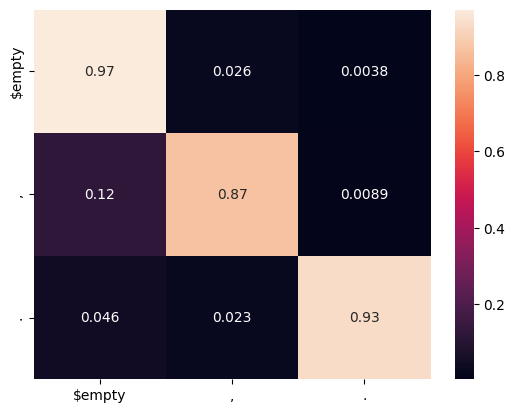

In [8]:
with torch.no_grad():
    model.eval()
    model.cpu()
    y_test_pred = model(x_test)
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred_ = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(y_test, dim = 1)
    y_test_ = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test_, y_pred_, normalize="true")).rename(
        columns=params['ID_TO_PUNCTUATION'], index=params['ID_TO_PUNCTUATION'])
sns.heatmap(confusion_matrix_df, annot=True)

In [15]:
params['ID_TO_PUNCTUATION']

{0: '$empty', 1: ',', 2: '.'}

In [13]:
import shap
import scipy as sp
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
import dataset_builder
importlib.reload(dataset_builder)
model.eval()
model.cuda()

import functools
@functools.lru_cache
def cached_word_features(tokens):
    return dataset_builder.get_word_features(tokens, params)

def inference(tokens_list):
    res = []
    features = torch.stack([
        torch.stack([cached_word_features(token) for token in tokens])
        for tokens in tokens_list])
    with torch.no_grad():
        model_pred = model(features.cuda().float())
        # _, val  = torch.max(model_pred, dim = 1)
        # res.append(val[0].item())
        outputs = model_pred.cpu().numpy()
        scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
        val = sp.special.logit(scores)
    return val
    # trainer.model

masker = shap.maskers.Text(dataset_builder.build_tokens, mask_token="UNDEF", collapse_mask_token=False, output_type="token_ids")

explainer = shap.Explainer(inference, masker, max_evals=1000, output_names=["empty", ',', '.'])
# explainer = shap.explainers.Permutation(trainer.model, max_evals=3541)

for i in range(650, 700):
    text = text_res[i]
    text_input = list(text.copy())
    del text_input[params['INPUT_WORDS_CNT_LEFT']]

    model_res = inference([text_input])[0]
    if np.argmax(model_res) == np.argmax(y_test[i].cpu().numpy()): 
        continue
    # if is_infected[i] != 0:
    #     continue
    # if np.argmax(model_res) != 2: continue

    text = " ".join(text)
    text_input = " ".join(text_input)
    print(f"TARGET({i}):", text)
    print("INPUT:", text_input)
    print("OUTPUT:", model_res)
    print(y_test[i])
    print("Infected type: ", params['ID_TO_INFECT_TYPE'][is_infected[i].item()])
    # print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
    shap_values = explainer([text_input])
    shap.plots.text(shap_values)
    print("=" * 100)
    print()
    print()
    print()
    print()
    print()
    print()
    print("=" * 100)

TARGET(678): бы вмешиваться в уличную ссору , но Ремигий любил приключения и был то , что называется  #,#  забияка . Не раздумывая , он бросился вперед , и через несколько минут его спор с
INPUT: бы вмешиваться в уличную ссору , но Ремигий любил приключения и был то , что называется забияка . Не раздумывая , он бросился вперед , и через несколько минут его спор с
OUTPUT: [ 2.0788581 -2.0838459 -7.6168046]
tensor([0., 1., 0.])
Infected type:  CORRECT_PUNCT_RIGHT








TARGET(681): и . был то , что называется , забияка . Не раздумывая , он бросился вперед  #,#  и через несколько минут его спор с сирийцем перешел в ожесточенную брань Когда я отважился приблизиться
INPUT: и . был то , что называется , забияка . Не раздумывая , он бросился вперед и через несколько минут его спор с сирийцем перешел в ожесточенную брань Когда я отважился приблизиться
OUTPUT: [ 0.55832654 -0.5603718  -7.6552877 ]
tensor([0., 1., 0.])
Infected type:  INCORRECT_PUNCT_RANDOM_PLACE


In [8]:
y_test

array([0, 0, 2, ..., 1, 0, 0])

In [ ]:
def full_text_inference():
    tokens = [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_LEFT'] + \
            dataset_builder.build_tokens(text, False)['input_ids'] + \
            [dataset_builder.PAD_TOKEN] * params['INPUT_WORDS_CNT_RIGHT']
    for pos in 
        for i in range(params["INPUT_WORDS_CNT_RIGHT"] + 1):
        input.append(PAD_TOKEN)
        output.append(NO_PUNCT)
    dataset_builder

In [ ]:
text = 'PAD ' * 8 + 'Мама пришла , кот съел еду'+ ' PAD' * 7
text_input = text.split()
del text_input[params['INPUT_WORDS_CNT_LEFT']]

model_res = inference([text_input])[0]

text = " ".join(text)
text_input = " ".join(text_input)
print("TARGET:", text)
print("INPUT", text_input)
print("OUTPUT:", model_res)
# print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
shap_values = explainer([text_input])
shap.plots.text(shap_values)

TARGET: P A D   P A D   P A D   P A D   P A D   P A D   P A D   P A D   М а м а   п р и ш л а   ,   к о т   с ъ е л   е д у   P A D   P A D   P A D   P A D   P A D   P A D   P A D
INPUT PAD PAD PAD PAD PAD PAD PAD PAD Мама пришла кот съел еду PAD PAD PAD PAD PAD PAD PAD
OUTPUT: [  3.6143982  -3.615273  -10.711602 ]


In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()


In [ ]:
model = trainer.model.to('cpu:0')

from timeit import default_timer as timer
start = timer()
with torch.no_grad():
    trainer.model(trainer.dataset.x_test)
end = timer()
print(len(trainer.dataset.x_test) / (end - start) / 32, "words per sec")

_ = trainer.model.cuda()

In [ ]:


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore